In [206]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_boston
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale
from sklearn import preprocessing
import matplotlib.pyplot as plt
import joblib
import plotly.io as pio
pio.renderers.default = 'jupyterlab'
 

In [207]:
import xgboost as xgb

In [208]:
new_data1 = joblib.load('new_data1.joblib')
new_data1.head(3)

,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions
0,NonResidential,Hotel,downtown,47.61220,-122.33799,1927,1.0,12,88434,7226362.5,2003882.0,3946027.0,1276453.0,249.98
1,NonResidential,Hotel,downtown,47.61317,-122.33393,1996,1.0,11,103566,8387933.0,0.0,3242851.0,5145082.0,295.86
2,NonResidential,Hotel,downtown,47.61393,-122.33810,1969,1.0,41,956110,72587024.0,21566554.0,49526664.0,1493800.0,2089.28


In [209]:
# one-hot-encoding
def get_ohe(df, column_name):
    ohe = OneHotEncoder(sparse=False)
    ohe.fit(df[[column_name]])
    temp_df = pd.DataFrame(data=ohe.transform(df[[column_name]]), columns=ohe.get_feature_names_out())
    df.drop(columns=[column_name], axis=1, inplace=True)
    df = pd.concat([df.reset_index(drop=True), temp_df], axis=1)
    return df

new_data1 = get_ohe(new_data1, 'BuildingType')
new_data1 = get_ohe(new_data1, 'PrimaryPropertyType')
new_data1 = get_ohe(new_data1, 'Neighborhood')

## Total GHG Emissions

In [210]:
y = new_data1[['TotalGHGEmissions']]

#Je sélectionne toutes les colonnes sauf la dernière (qui est ma cible) pour les mettre dans la variable X
X = new_data1.drop(['SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'], axis=1)

In [211]:
std_scale = preprocessing.StandardScaler().fit(X)
X_std = std_scale.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.25)

In [212]:
xgbr = xgb.XGBRegressor(verbosity=1, n_estimators=1000, max_depth=30, gamma=0.20, eval_metric = 'mae') 
xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.25,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=20, min_child_weight=3, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=0)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.25, gpu_id=None, grow_policy=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_to_onehot=None,
             max_delta_step=0, max_depth=20, max_leaves=None,
             min_child_weight=3, missing=None, monotone_constraints=None,
             n_estimators=100, n_jobs=1, nthread=None, num_parallel_tree=None,
             predictor=None, random_state=0, reg_alpha=0, ...)

In [213]:
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='mae', gamma=0.2, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=30, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [214]:

ypred = xgbr.predict(X_test)

mse = mean_squared_error(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
r2 = r2_score(y_test, ypred)
mape = mean_absolute_percentage_error(y_test, ypred)
print("MAE: %.2f" % mae)
print("R2: %.2f" % r2)
print("MSE: %.2f" % mse)
print("MAPE: %.2f" % mape)



MAE: 114.58
R2: 0.40
MSE: 76565.18
MAPE: 588917387491024.00


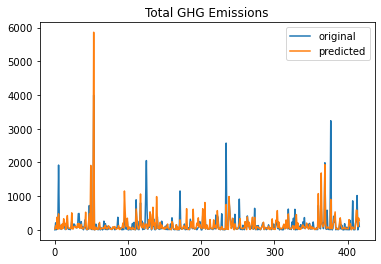

In [215]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, ypred, label="predicted")
plt.title("Total GHG Emissions")
plt.legend()
plt.show()

In [216]:
# feature importance
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance


perm_importance = permutation_importance(xgbr, X_train, y_train)

feature_names = X.columns
features = np.array(feature_names)

Text(0.5, 0, 'Permutation Importance')

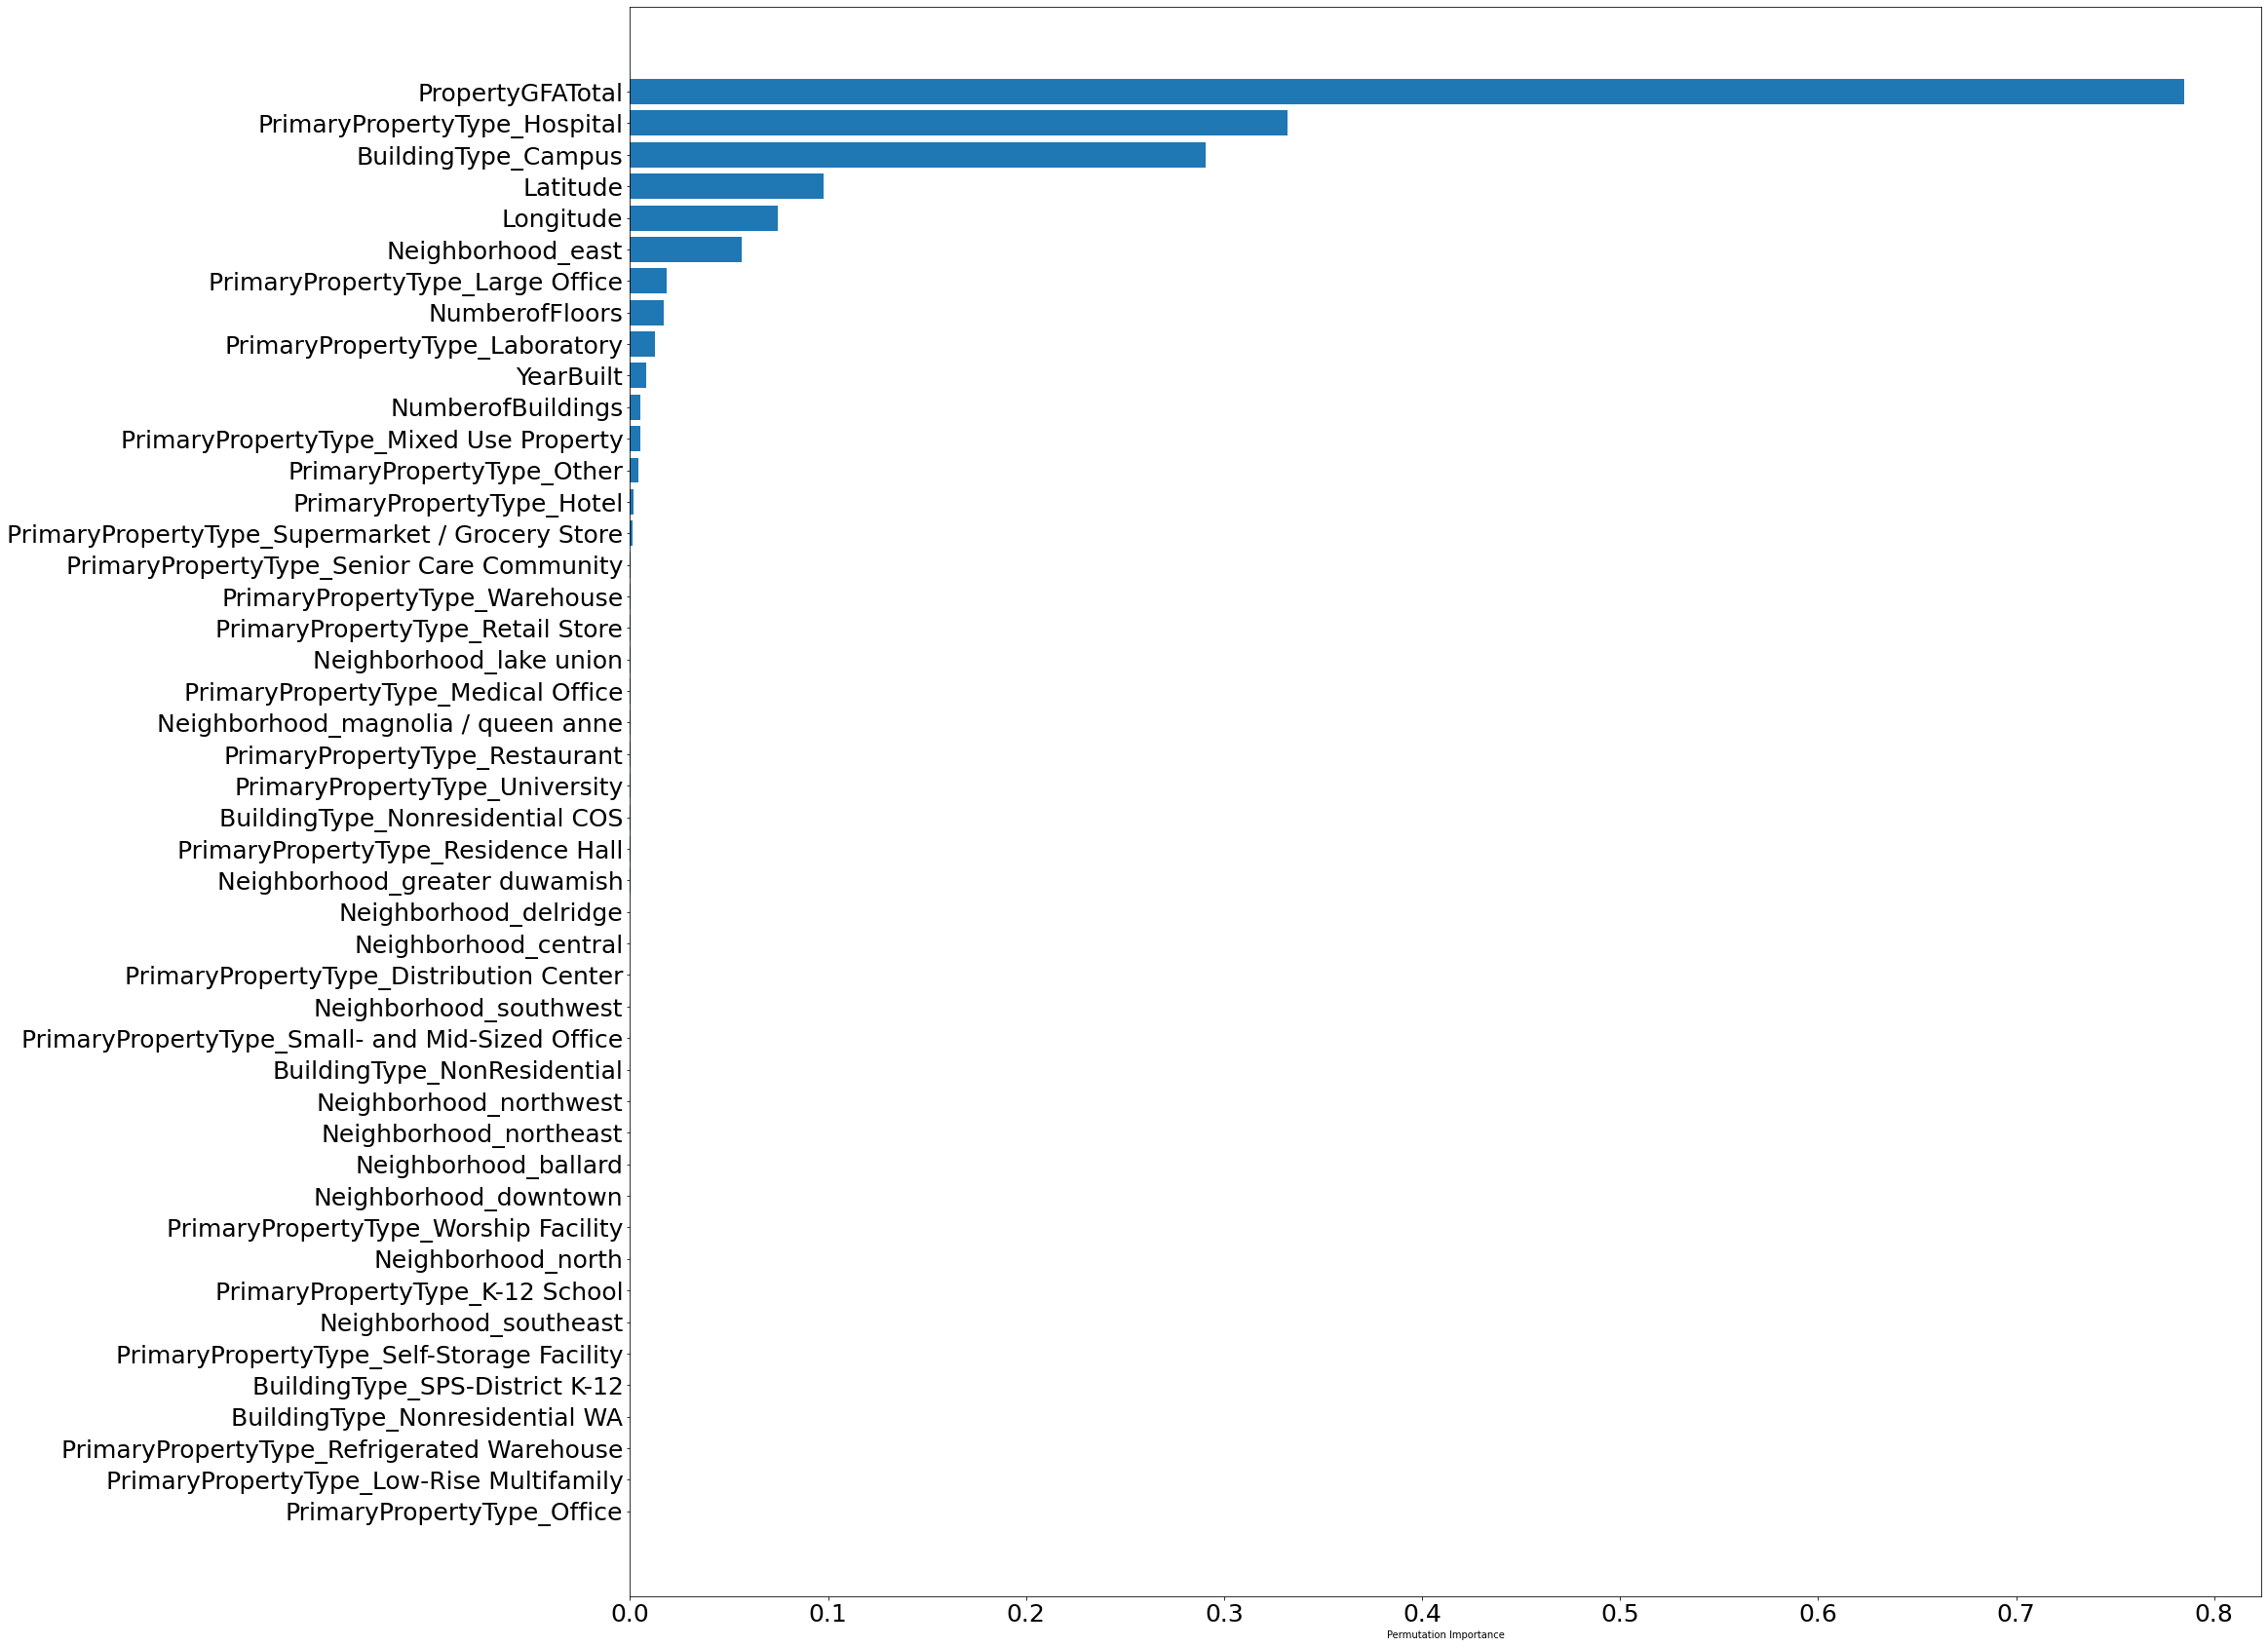

In [217]:
plt.figure(figsize=(30,30))
plt.yticks(
        rotation=0, 
        horizontalalignment='right',
        fontweight='light',
        fontsize=25 
)
plt.xticks(
        rotation=0, 
        fontweight='light',
        fontsize=25
)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [218]:

learning_rate_range  = [0.001, 0.01, 0.1, 0.2]
gamma_range = [0, 0.25, 0.5]
max_depth_range = [6, 10, 15, 20]
n_estimators_range = [300, 500, 1000]
min_child_weight_range = [3.0, 5.0, 7.0, 10.0, 12.0]

param_xgbr = {'learning_rate' : learning_rate_range,
             'max_depth': max_depth_range,
             'gamma': gamma_range,
             'min_child_weight' : min_child_weight_range,
             'n_estimators' : n_estimators_range
             }

In [219]:
from sklearn.model_selection import RandomizedSearchCV
score = 'neg_mean_absolute_error'

grid_pred = RandomizedSearchCV(xgb.XGBRegressor(),
        param_xgbr,
        cv=5,
        scoring=score)
                                    
grid_pred.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None,
                                          reg_alpha=None, reg_lambda=None, ...),
                   param_distributions={'gamma': [0, 0.25, 0.5],
                                        'learning_rate': [0.001, 0.01, 0.1,
                                                          0.2],
                                        'max_depth': [6, 10, 15, 20],
                                        'min_child_weight': [3.0, 5.0, 7.0,
                                                             10.0, 12.0],
                                        'n_estimators': [300, 500, 1000]},
                   scoring='neg_mean_absolute_error')

In [220]:
print(grid_pred.best_params_)

{'n_estimators': 300, 'min_child_weight': 12.0, 'max_depth': 6, 'learning_rate': 0.001, 'gamma': 0.5}


In [221]:
best_grid = grid_pred.best_estimator_
y_test_pred_cv = best_grid.predict(X_test)

mae_cv = mean_absolute_error(y_test, y_test_pred_cv)
mse_cv = mean_squared_error(y_test, y_test_pred_cv)
mape_cv = mean_absolute_percentage_error(y_test, y_test_pred_cv)
r2_cv = r2_score(y_test,y_test_pred_cv)

In [222]:
print("MAE_cv : " , mae_cv)
print("R2_cv : ", r2_cv)
print("MSE_cv : ", mse_cv)
print("MAPE_cv : ", mape_cv)

MAE_cv :  127.50215947551408
R2_cv :  0.05037378575060847
MSE_cv :  121753.43964288014
MAPE_cv :  151809481457783.38


## Site Energy Use (kBtu)

In [223]:
y2 = new_data[['SiteEnergyUse(kBtu)']]
X2 = new_data.drop(['SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'], axis=1)
std_scale2 = preprocessing.StandardScaler().fit(X2)
X_std2 = std_scale2.transform(X2)

X_train, X_test, y_train, y_test = train_test_split(X_std2, y2, test_size=0.25)

In [224]:
xgbr2 = xgb.XGBRegressor(verbosity=1, n_estimators=1000, max_depth=20, gamma=0.20, eval_metric = 'mae') 
xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.25,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=20, min_child_weight=3, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=0)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.25, gpu_id=None, grow_policy=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_to_onehot=None,
             max_delta_step=0, max_depth=20, max_leaves=None,
             min_child_weight=3, missing=None, monotone_constraints=None,
             n_estimators=100, n_jobs=1, nthread=None, num_parallel_tree=None,
             predictor=None, random_state=0, reg_alpha=0, ...)

In [225]:
xgbr2.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='mae', gamma=0.2, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [226]:
y_pred2 = xgbr2.predict(X_test)

In [227]:

mse2 = mean_squared_error(y_test, y_pred2)
mae2 = mean_absolute_error(y_test, y_pred2)
r2_2 = r2_score(y_test, y_pred2)
mape2 = mean_absolute_percentage_error(y_test, y_pred2)

print("MAE: %.2f" % mae2)
print("R2: %.2f" % r2_2)
print("MSE: %.2f" % mse2)
print("MAPE: %.2f" % mape2)



MAE: 4692756.96
R2: 0.29
MSE: 262691483859559.28
MAPE: 82399839232206733312.00


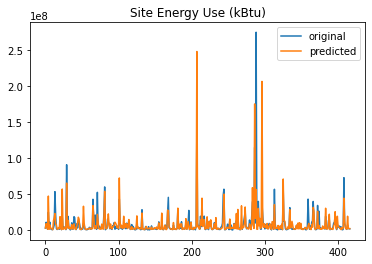

In [228]:
x_ax2 = range(len(y_test))
plt.plot(x_ax2, y_test, label="original")
plt.plot(x_ax2, y_pred2, label="predicted")
plt.title("Site Energy Use (kBtu)")
plt.legend()
plt.show()

Text(0.5, 0, 'Permutation Importance')

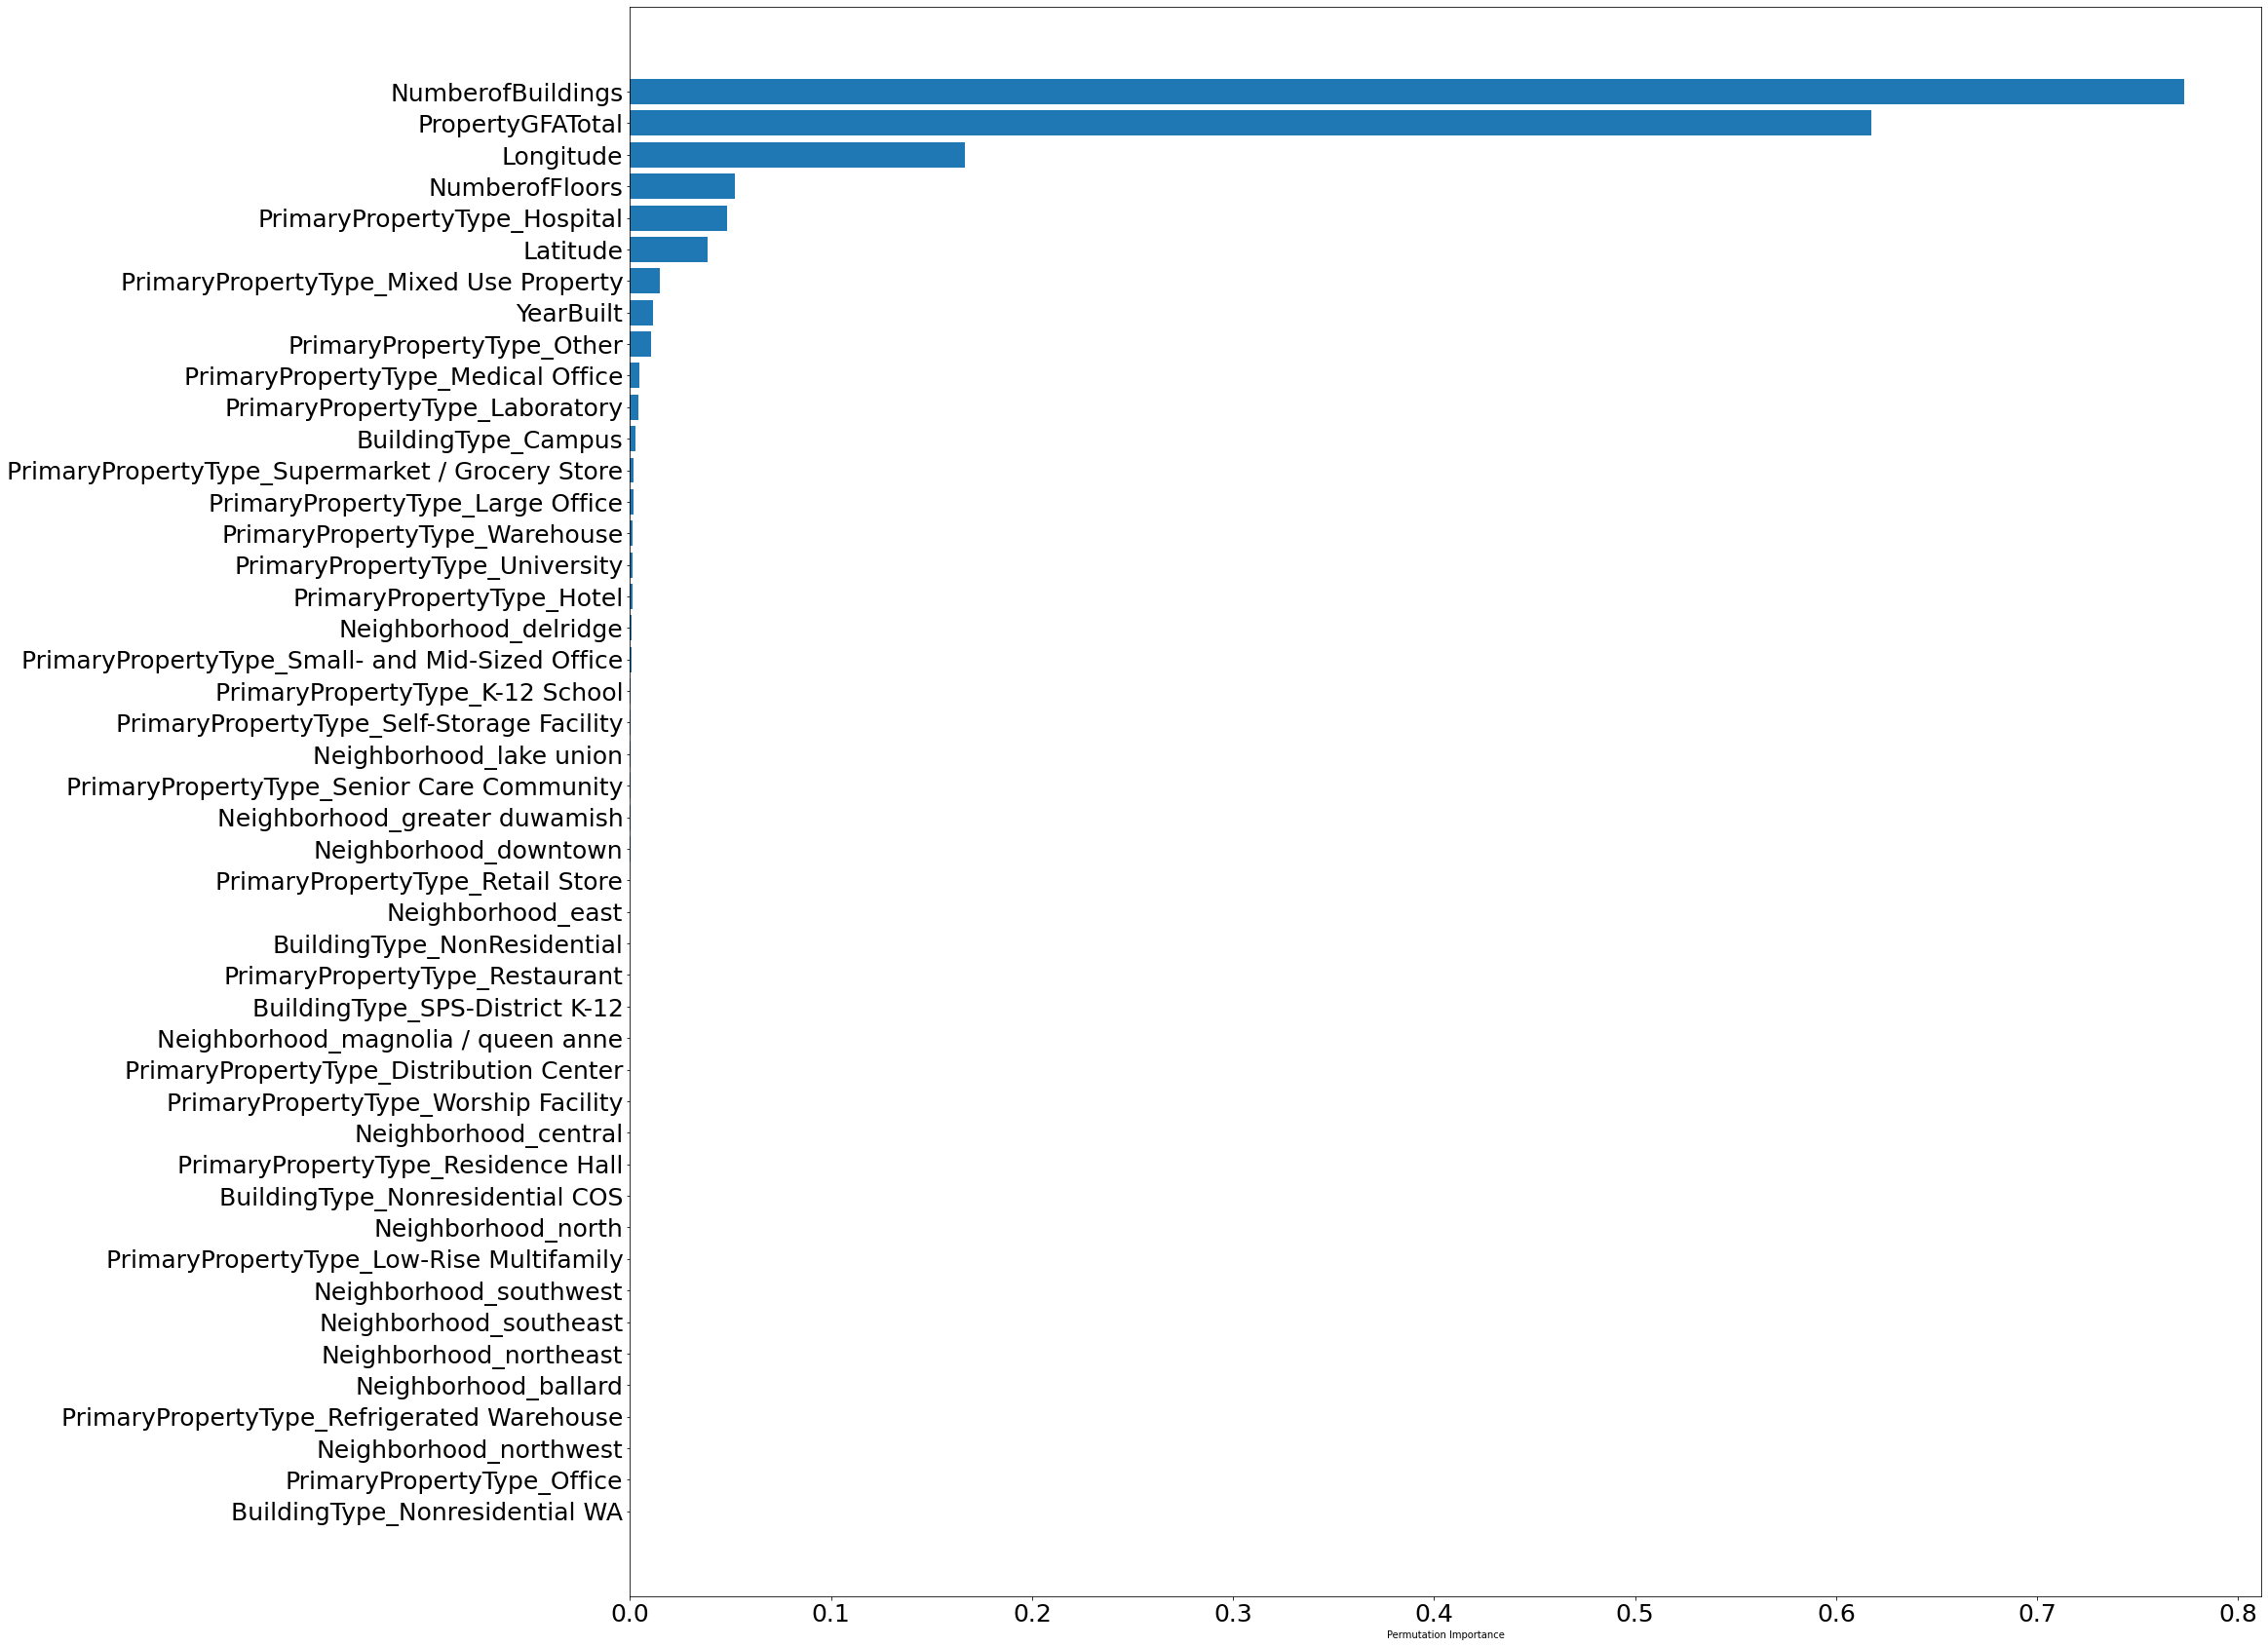

In [229]:
perm_importance2 = permutation_importance(xgbr2, X_train, y_train)

feature_names2 = X2.columns
features2 = np.array(feature_names2)

plt.figure(figsize=(30,30))
plt.yticks(
        rotation=0, 
        horizontalalignment='right',
        fontweight='light',
        fontsize=25 
)
plt.xticks(
        rotation=0, 
        fontweight='light',
        fontsize=25
)
sorted_idx2 = perm_importance2.importances_mean.argsort()
plt.barh(features2[sorted_idx2], perm_importance2.importances_mean[sorted_idx2])
plt.xlabel("Permutation Importance")

In [230]:
import numpy as np
learning_rate_range  = [0.001, 0.01, 0.1, 0.2]
gamma_range = [0, 0.25, 0.5]
max_depth_range = [6, 10, 15, 20]
n_estimators_range = [1000, 2000]
min_child_weight_range = [3.0, 5.0, 7.0, 10.0, 12.0]

param_xgbr2 = {'learning_rate' : learning_rate_range,
             'max_depth': max_depth_range,
             'gamma': gamma_range,
             'min_child_weight' : min_child_weight_range,
             'n_estimators' : n_estimators_range
             }

In [231]:
from sklearn.model_selection import RandomizedSearchCV
score = 'neg_mean_absolute_error'

grid_pred2 = RandomizedSearchCV(xgb.XGBRegressor(eval_metric ='mae'),
        param_xgbr2,
        cv=5,
        scoring=score)
                                    
grid_pred2.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric='mae', gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,...
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None,
                                          reg_alpha=None, reg_lambda=None, ...),
                   param_distributions={'gamma': [0, 0.25, 0.5],
                                        'learning_rate': [0.001, 0.01, 0.1,
                                                          0.2],
                                        'max_depth': [6, 10, 15, 20],
                                        'min_child_weight': [3.0, 5.0, 7.0,
                                                             10.0, 12.0],
                                        'n_estimators': [1000, 2000]},
                   scoring='neg_mean_absolute_error')

In [232]:
print(grid_pred2.best_params_)

{'n_estimators': 2000, 'min_child_weight': 7.0, 'max_depth': 10, 'learning_rate': 0.001, 'gamma': 0.5}


In [233]:
best_grid = grid_pred2.best_estimator_
y_test_pred_cv2 = best_grid.predict(X_test)

mae_cv2 = mean_absolute_error(y_test, y_test_pred_cv2)
mse_cv2 = mean_squared_error(y_test, y_test_pred_cv2)
mape_cv2 = mean_absolute_percentage_error(y_test, y_test_pred_cv2)
r2_cv2 = r2_score(y_test,y_test_pred_cv2)

In [234]:
print("MAE_cv : " , mae_cv2)
print("R2_cv : ", r2_cv2)
print("MSE_cv : ", mse_cv2)
print("MAPE_cv : ", mape_cv2)


MAE_cv :  3850878.2666097004
R2_cv :  0.4447191675256523
MSE_cv :  204466153161589.9
MAPE_cv :  9.254121119310586e+19
